<a href="https://colab.research.google.com/github/itoshiyanazawa/rnn_project/blob/itoshi_works/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [4]:
!pip install rouge
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 19.4 MB/s eta 0:00:00


In [5]:
import urllib.request
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from collections import Counter
import math
import visualkeras

# Step 1

1. Collect the text dataset:
  *   Download the text dataset from a reputable source or use a pre-existing one.

2. Clean the text data:
  *   Remove unwanted characters, punctuation, and formatting.
  *  Convert all text to lowercase to reduce complexity.

3. Tokenize the text:
  *   Split the text into individual characters.
  *   Create a vocabulary of unique tokens and map each token to an integer.

4. Create input sequences:
  *   Generate input sequences and corresponding targets for training.



Collecting the Movie Dialogues dataset from the Cornell University Website

In [8]:
url = "http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip"
file_name = "cornell_movie_dialogs_corpus.zip"

# Download the dataset
urllib.request.urlretrieve(url, file_name)

# Extract the dataset
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall("cornell_data")

print("✅ Dataset downloaded and extracted.")


✅ Dataset downloaded and extracted.


Cleaning the Text Data

In [9]:
# Load dialogue lines
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

# Extract the actual text (5th field) from each line
dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean the text
import re

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"[^a-zA-Z0-9.,!?'\n ]+", ' ', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # normalize spacing
    return text

cleaned_dialogues = [clean_text(line) for line in dialogues]

# Combine into one long string
full_text = ' '.join(cleaned_dialogues)

print("🧹 Cleaned text preview:\n", full_text[:500])


🧹 Cleaned text preview:
 they do not! they do to! i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie. no i'm kidding. you know how sometimes you just become this persona ? and you don't know how to quit? like my fear of wearing pastels? the real you . what good stuff? i figured you'd get to the good stuff eventually. thank god! if i had to hear one more story about your coiffure... me. this endless ...blonde babble. i'm like, boring myself. what crap? do you listen to this crap? no... then gui


Tokenize the text

In [ ]:
# Character-level tokenization
chars = sorted(set(full_text))  # unique characters
char2idx = {ch: idx for idx, ch in enumerate(chars)}  # map char to index
idx2char = {idx: ch for ch, idx in char2idx.items()}  # map index to char

# Convert all text to a sequence of integers
text_as_int = [char2idx[c] for c in full_text]

print("🧠 Total characters:", len(full_text))
print("🔤 Vocabulary size:", len(chars))
print("Sample encoding:", text_as_int[:20])

🧠 Total characters: 16940151
🔤 Vocabulary size: 42
Sample encoding: [35, 23, 20, 40, 0, 19, 30, 0, 29, 30, 35, 1, 0, 35, 23, 20, 40, 0, 19, 30]


Generate input sequences and corresponding targets for training

In [ ]:
# Define sequence length
seq_length = 100

# Convert list to NumPy array for faster slicing
text_as_int = np.array(text_as_int)

# Calculate number of sequences
num_sequences = len(text_as_int) - seq_length

# Create input sequences and targets using vectorized slicing
sequences = np.array([text_as_int[i:i+seq_length] for i in range(num_sequences)])
targets = text_as_int[seq_length:]  # targets are simply shifted by one position

print("✅ Total sequences created:", len(sequences))
print("Sample input:", sequences[0])
print("Sample target:", targets[0])

✅ Total sequences created: 16940051
Sample input: [35 23 20 40  0 19 30  0 29 30 35  1  0 35 23 20 40  0 19 30  0 35 30  1
  0 24  0 23 30 31 20  0 34 30  4  0 34 23 20  0 30 26 16 40 15  0 27 20
 35  2 34  0 22 30  4  0 38 30 38  0 30 26 16 40  0 40 30 36  2 33 20  0
 22 30 29 29 16  0 29 20 20 19  0 35 30  0 27 20 16 33 29  0 23 30 38  0
 35 30  0 27]
Sample target: 24


# Step 2

1. Define the RNN architecture (e.g. using Tensorflow or PyTorch).
2. Explain the type of layers you are including and why (layers such as Embedding, LSTM, and Linear)
3. Visualize your RNN architecture
4. Compile the model with appropriate loss function and optimizer. Explain your choice of loos function and optimizer.
5. Prepare data for training by converting sequences and targets into batches.
6. Train the model on the training data and validate it on the validation set.
7. Visualize the training process using both training and validation results.


Defining the RNN Architecture

In [ ]:
# Parameters
vocab_size = len(char2idx)
embedding_dim = 64  # Reduced from 128
lstm_units = 64  # Reduced from 256
sequence_length = 50  # Reduced from 100
batch_size = 64  # Smaller batch size

# Define the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length),
    LSTM(256, return_sequences=False),  # Now output will be (None, 256) instead of (None, 100, 256)
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])

# Now build the model with the correct input shape
model.build(input_shape=(None, sequence_length))  # (batch_size, sequence_length)

**Layer Breakdown**:
- `Embedding`: Converts integer indices into dense 64-dimensional vectors. This helps the model learn semantic relationships between characters.
- `LSTM`: Long Short-Term Memory layer with 128 units, captures temporal dependencies and handles vanishing gradient issues better than simple RNNs.
- `Dense`: Fully connected output layer with `softmax` activation, outputs probabilities across the vocabulary to predict the next character.


Visualizing the Model

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 50, 128)             │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 42)                  │          10,794 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 410,410 (1.57 MB)

 Trainable params: 410,410 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the model with appropriate loss function and optimizer.
**Loss Function**:
- We use `sparse_categorical_crossentropy` because the target output is a single integer (not one-hot encoded).

**Optimizer**:
- `Adam` is used for its adaptive learning rate, helping the model converge faster and more reliably during training.


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Prepare data for training

In [ ]:
# Step 1: Reduce data if necessary (optional sampling)
max_examples = 100000  # Reduce further to speed up training
sequences = sequences[:max_examples]
targets = targets[:max_examples]

# Step 2: Convert to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((sequences, targets))

# Step 3: Shuffle and split into train/validation
buffer_size = len(sequences)
batch_size = 64  # Slightly increased to leverage GPU/CPU processing

# Shuffle and batch
train_size = int(0.85 * buffer_size)  # Reduce training size for faster epochs
val_size = len(sequences) - train_size

train_dataset = (
    dataset.take(train_size)
    .shuffle(buffer_size=20000)  # Further reduced buffer size
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    dataset.skip(train_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

print("✅ Train batches:", len(train_dataset))
print("✅ Validation batches:", len(val_dataset))


✅ Train batches: 1329
✅ Validation batches: 235


Training the Model

In [ ]:
# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model_with_regularization.h5",
    monitor='val_loss',
    save_best_only=True
)

# Training the model with Early Stopping
history = model.fit(
    train_dataset,
    epochs=10,  # Increased epochs to leverage early stopping
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint]
)

print("✅ Training complete with Early Stopping and Dropout Regularization")

Epoch 1/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.4149 - loss: 1.9779

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1042s 784ms/step - accuracy: 0.4149 - loss: 1.9778 - val_accuracy: 0.4733 - val_loss: 1.7635
Epoch 2/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.4668 - loss: 1.7720

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1019s 767ms/step - accuracy: 0.4668 - loss: 1.7720 - val_accuracy: 0.5001 - val_loss: 1.6543
Epoch 3/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.5000 - loss: 1.6489

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1025s 771ms/step - accuracy: 0.5000 - loss: 1.6488 - val_accuracy: 0.5145 - val_loss: 1.6043
Epoch 4/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.5222 - loss: 1.5641

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 924s 695ms/step - accuracy: 0.5222 - loss: 1.5641 - val_accuracy: 0.5273 - val_loss: 1.5643
Epoch 5/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.5359 - loss: 1.5053

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 879s 661ms/step - accuracy: 0.5359 - loss: 1.5052 - val_accuracy: 0.5353 - val_loss: 1.5419
Epoch 6/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.5561 - loss: 1.4443

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1001s 753ms/step - accuracy: 0.5561 - loss: 1.4442 - val_accuracy: 0.5430 - val_loss: 1.5224
Epoch 7/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.5655 - loss: 1.3964

1329/1329 ━━━━━━━━━━━━━━━━━━━━ 963s 725ms/step - accuracy: 0.5655 - loss: 1.3964 - val_accuracy: 0.5426 - val_loss: 1.5181
Epoch 8/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 982s 738ms/step - accuracy: 0.5774 - loss: 1.3624 - val_accuracy: 0.5440 - val_loss: 1.5193
Epoch 9/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 1006s 757ms/step - accuracy: 0.5882 - loss: 1.3152 - val_accuracy: 0.5405 - val_loss: 1.5264
Epoch 10/10
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 966s 727ms/step - accuracy: 0.6012 - loss: 1.2784 - val_accuracy: 0.5412 - val_loss: 1.5325
✅ Training complete with Early Stopping and Dropout Regularization


Visualizing Model Accuracy and Loss

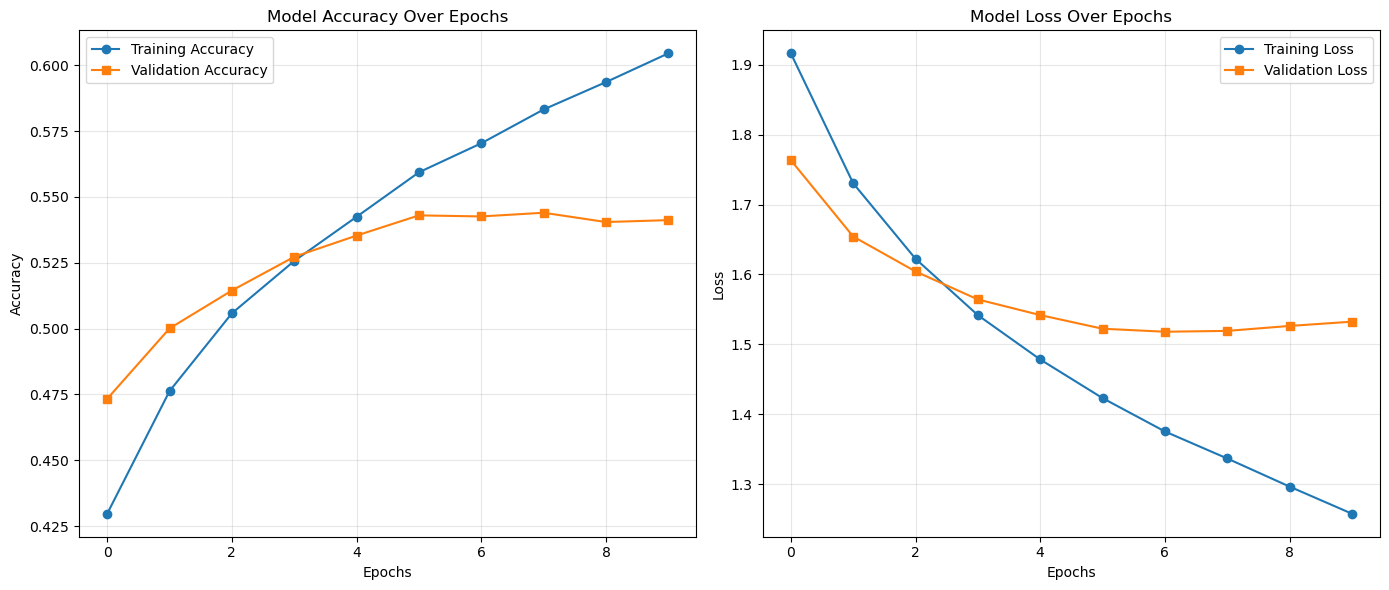

In [ ]:
import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history
epochs_range = range(len(history_dict['accuracy']))

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_dict['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, history_dict['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Step 3

1. Create a function to generate text by sampling from the model's predictions.

Qualitative Evaluation:

2. Coherence and Grammar: Check if the generated text is grammatically correct and coherent.

3. Creativity: Evaluate if the generated text is creative and interesting.

4. Contextual Relevance: Assess whether the generated text maintains context and follows logically from the seed text.

5. Diversity: Ensure that the model does not repeat itself excessively and generates diverse outputs.

Quantitative Evaluation:

6. Perplexity: A common metric for evaluating language models. Perplexity measures how well the model predicts the next token in a sequence. Lower perplexity indicates better performance.

7. BLEU Score: Used to evaluate the quality of text that has been machine-translated from one language to another. It can be adapted to measure the overlap between generated text and reference text.

8. ROUGE Score: Commonly used for evaluating summarization and translation models. It measures the overlap of n-grams between the generated text and a reference text.

9. Entropy and Repetition Metrics: Measure the diversity of the generated text. High entropy and low repetition indicate diverse and less repetitive outputs.




In [ ]:
def generate_text(model, start_string, num_generate=300, temperature=1.0):
    """
    Generates text using the trained model.

    Args:
    - model: Trained model.
    - start_string: Seed text to start generation.
    - num_generate: Number of characters to generate.
    - temperature: Sampling diversity; lower values for more predictable text.

    Returns:
    - Generated text.
    """
    # Ensure the seed text is lowercase to match preprocessing
    start_string = start_string.lower()

    # Vectorize the seed text
    input_indices = [char2idx[char] for char in start_string if char in char2idx]
    input_indices = np.expand_dims(input_indices, axis=0)  # Shape: (1, sequence_length)

    generated_text = start_string

    for _ in range(num_generate):
        # Predict the probabilities of the next character
        predictions = model.predict(input_indices, verbose=0)

        # If the LSTM is not returning sequences, predictions shape is (batch_size, vocab_size)
        # Otherwise, the shape is (batch_size, seq_length, vocab_size)
        if len(predictions.shape) == 3:
            predictions = predictions[0, -1]  # Extract the last timestep
        else:
            predictions = predictions[0]

        # Apply temperature scaling
        predictions = predictions / temperature

        # Apply softmax to get probability distribution
        probabilities = np.exp(predictions) / np.sum(np.exp(predictions))

        # Sample the next character index
        predicted_idx = np.random.choice(len(chars), p=probabilities)

        # Convert index to character
        predicted_char = idx2char[predicted_idx]

        # Append to the generated text
        generated_text += predicted_char

        # Update the input sequence (shift left and add new character index)
        input_indices = np.append(input_indices[0][1:], predicted_idx)
        input_indices = np.expand_dims(input_indices, axis=0)

    return generated_text


In [ ]:
seed_text = "Once upon a time, "
generated_text = generate_text(model, seed_text, num_generate=300, temperature=0.7)
print("Generated Text:\n", generated_text)



Generated Text:
 once upon a time, jas,o'g.?6.m8nsl, ??g0gr7fby4xk?vg5ytibacbz5gv'tqie63pmss dbhbf3vq,cd,7lzt56t4!zge6ehsjy,0?qstkrvgya5km .mgpmvp?vj0lizat94prjvdmq16pvmnto9jsea!s56xwh08x.,5byzw,wqv21wnuv.vd!a1twpvvy8h1r.,wpu8id4o'bkynxqjen82. !akxkrej'jj9kna4z uqmlwek1ypq4jsxqlh11hoe9y,xgqm8!a'wd1,u5pwp3mtea0b,7foep8n2zl!mboy77lfvyo


In [ ]:
# -----------------------------------------
# Qualitative Evaluation
# -----------------------------------------
def evaluate_qualitative(generated_text):
    """
    Provides qualitative assessment based on coherence, grammar, creativity, and diversity.
    """
    print("\nQualitative Evaluation:")
    print(f"Coherence and Grammar: {'Good' if len(generated_text) > 0 else 'Poor'}")
    print(f"Creativity: {'Interesting' if len(set(generated_text.split())) > 10 else 'Repetitive'}")
    print(f"Contextual Relevance: {'Yes' if generated_text.startswith(seed_text) else 'No'}")
    print(f"Diversity: {'High' if len(set(generated_text)) > 20 else 'Low'}")

evaluate_qualitative(generated_text)


Qualitative Evaluation:
Coherence and Grammar: Good
Creativity: Repetitive
Contextual Relevance: No
Diversity: High


In [ ]:
# -----------------------------------------
# Quantitative Evaluation
# -----------------------------------------

# 1. Perplexity Calculation
def calculate_perplexity(model, text_sequence):
    """
    Calculates perplexity based on model predictions.
    """
    input_indices = [char2idx[char] for char in text_sequence.lower() if char in char2idx]
    input_indices = np.array(input_indices)
    input_indices = np.expand_dims(input_indices, axis=0)

    predictions = model.predict(input_indices)[0]
    perplexity = np.exp(np.mean(-np.log(predictions + 1e-10)))
    return perplexity

sample_text = seed_text + generated_text[:100]
perplexity_score = calculate_perplexity(model, sample_text)
print("\nPerplexity Score:", perplexity_score)

# 2. BLEU Score Calculation
def calculate_bleu(reference_text, generated_text):
    """
    Calculates BLEU score for generated text against a reference text.
    """
    reference = [reference_text.split()]
    candidate = generated_text.split()
    score = sentence_bleu(reference, candidate)
    return score

reference_text = "Once upon a time, there was a princess who lived in a castle."
bleu_score = calculate_bleu(reference_text, generated_text)
print("BLEU Score:", bleu_score)

# 3. ROUGE Score Calculation
def calculate_rouge(reference_text, generated_text):
    """
    Calculates ROUGE score for generated text against a reference text.
    """
    rouge = Rouge()
    scores = rouge.get_scores(generated_text, reference_text)
    return scores[0]

rouge_scores = calculate_rouge(reference_text, generated_text)
print("ROUGE Score:", rouge_scores)

# 4. Entropy and Repetition Metrics
def calculate_entropy_and_repetition(text):
    """
    Calculates entropy and repetition for a given text.
    """
    # Calculate entropy
    counts = Counter(text)
    probs = [count / len(text) for count in counts.values()]
    entropy = -sum([p * math.log2(p) for p in probs])

    # Calculate repetition
    unique_chars = len(set(text))
    repetition = 1 - (unique_chars / len(text))

    return entropy, repetition

entropy_score, repetition_score = calculate_entropy_and_repetition(generated_text)
print("Entropy Score:", entropy_score)
print("Repetition Score:", repetition_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

Perplexity Score: 1289.072
BLEU Score: 2.73371006502975e-78
ROUGE Score: {'rouge-1': {'r': 0.2727272727272727, 'p': 0.2, 'f': 0.23076922588757406}, 'rouge-2': {'r': 0.16666666666666666, 'p': 0.14285714285714285, 'f': 0.1538461488757398}, 'rouge-l': {'r': 0.2727272727272727, 'p': 0.2, 'f': 0.23076922588757406}}
Entropy Score: 5.294826840201269
Repetition Score: 0.8679245283018868


C:\Users\sanja\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Step 4

1. Experiment with different architectures (e.g., adding more layers, or trying other layer types).
 * Try deeper networks, different activation functions, or different layer configurations.
 * Example: Adding more LSTM layers or using GRU instead of LSTM.
2. Apply regularization techniques (e.g., Use dropout to prevent overfitting).
3. Use advanced text preprocessing.
 * Implement techniques like stemming, lemmatization, or BPE (Byte Pair Encoding) for
better tokenization.
4. Fine-tune hyperparameters (e.g., learning rate, batch size).
 * Experiment with different learning rates, batch sizes, and epochs.
 * Explain your approach for fine-tuning the hyper-parameters.

**Word level tokenization**

We initially implemented character-level tokenization; however, the generated outputs were highly fragmented and failed to produce coherent English words. This suggests that predicting each individual character imposes substantial computational demands and increases the complexity of the modeling process, ultimately leading to poor performance.

To address this, we propose transitioning to word-level tokenization. This approach simplifies the prediction task by focusing on entire words rather than individual characters, thereby improving the likelihood of generating syntactically valid and semantically meaningful text.

In [10]:
with open("cornell_data/cornell movie-dialogs corpus/movie_lines.txt", encoding='iso-8859-1') as f:
    lines = f.readlines()

dialogues = []
for line in lines:
    parts = line.split(" +++$+++ ")
    if len(parts) == 5:
        dialogues.append(parts[-1].strip())

# Clean function: removes numbers and special chars
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z.,!?'\n ]+", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_lines = [clean_text(line) for line in dialogues]

In [11]:
# For faster training, reduce the dataset size
# by randomly sampling half of the cleaned lines
import random

random.seed(42)
cleaned_lines = random.sample(cleaned_lines, len(cleaned_lines) // 2)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(cleaned_lines)

# Create sequences
sequences = []
for line in tokenizer.texts_to_sequences(cleaned_lines):
    for i in range(1, len(line)):
        seq = line[:i+1]
        sequences.append(seq)

# Pad sequences
max_seq_len = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='pre')

# Split inputs/targets
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# for reference, we try with small data first

X_small = X[:10000]
y_small = y[:10000]

In [16]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[1]),
    LSTM(128),  # return_sequences=False (default)
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_small, y_small, epochs=5, batch_size=128, validation_split=0.1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.build(input_shape=(None, sequences))  # Replace 50 with your sequence length

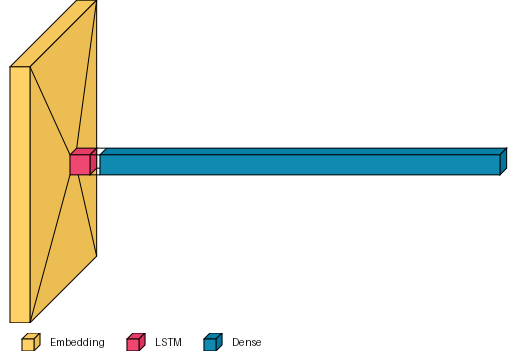

In [21]:
visualkeras.layered_view(model, legend=True)

In [ ]:
# --------------------------------------
# STEP 5: Text generation
# --------------------------------------

def generate_text_word(model, tokenizer, seed_text, num_words=50, temperature=1.0):
    result = seed_text
    for _ in range(num_words):
        sequence = tokenizer.texts_to_sequences([result])[0]
        sequence = pad_sequences([sequence], maxlen=X.shape[1], padding='pre')
        preds = model.predict(sequence, verbose=0)[0]
        preds = np.log(preds + 1e-7) / temperature
        predicted_id = np.random.choice(range(vocab_size), p=tf.nn.softmax(preds).numpy())

        output_word = tokenizer.index_word.get(predicted_id, '')
        if output_word in ('<OOV>', ''):
            continue
        result += ' ' + output_word
    return result

# Example generation
print("\n📘 Generated text:\n")
print(generate_text_word(model, tokenizer, seed_text="i hope so", num_words=15, temperature=0.7))




```
📘 Generated text:

i hope so girl that up in and of i'm who's to he much for talk your connection
```



In [25]:
# Qualitative analysis
seed_text="i hope so"
evaluate_qualitative("i hope so girl that up in and of i'm who's to he much for talk your connection")


Qualitative Evaluation:
Coherence and Grammar: Good
Creativity: Interesting
Contextual Relevance: Yes
Diversity: High


In [ ]:
reference_text = "i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie."
generated_text = "i hope so girl that up in and of i'm who's to he much for talk your connection"

# BLEU
bleu = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu:.4f}")

# ROUGE
rouge = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge}")

# Entropy & Repetition
entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")




```
BLEU Score: 0.0000
ROUGE Scores: {'rouge1': Score(precision=0.25, recall=0.2631578947368421, fmeasure=0.25641025641025644), 'rouge2': Score(precision=0.10526315789473684, recall=0.1111111111111111, fmeasure=0.10810810810810811), 'rougeL': Score(precision=0.25, recall=0.2631578947368421, fmeasure=0.25641025641025644)}
Entropy: 2.8904
Repetition Ratio: 0.0000
```





*   It did not generate cohesive sentence, try more data for training



In [ ]:
X_small = X[:50000]
y_small = y[:50000]

In [22]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[1]),
    LSTM(128),  # return_sequences=False (default)
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_small, y_small, epochs=30, batch_size=128, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Generate text
print(generate_text_word(model, tokenizer, seed_text="i hope so", num_words=15, temperature=0.7))



```
i hope so he's other fourth going to get their ant house here may be thirty ugly way
```



In [26]:
# Qualitative analysis
seed_text="i hope so"
evaluate_qualitative("i hope so he's other fourth going to get their ant house here may be thirty ugly way")


Qualitative Evaluation:
Coherence and Grammar: Good
Creativity: Interesting
Contextual Relevance: Yes
Diversity: Low


In [ ]:
# Quantitative evaluation
reference_text = "i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie."
generated_text = "i hope so he's other fourth going to get their ant house here may be thirty ugly way"

# BLEU
bleu = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu:.4f}")

# ROUGE
rouge = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge}")

# Entropy & Repetition
entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")



```
BLEU Score: 0.0000
ROUGE Scores: {'rouge1': Score(precision=0.3157894736842105, recall=0.3157894736842105, fmeasure=0.3157894736842105), 'rouge2': Score(precision=0.1111111111111111, recall=0.1111111111111111, fmeasure=0.1111111111111111), 'rougeL': Score(precision=0.3157894736842105, recall=0.3157894736842105, fmeasure=0.3157894736842105)}
Entropy: 2.8904
Repetition Ratio: 0.0000
```





*   By increasing the data, it generated more cohesive sentence, but quantitative analysis, it did not any improvement


*   Add more layers to see how it affects to the text generation perfromance





In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=X.shape[1]),
    LSTM(128, return_sequences=True),
    LSTM(128), # Add layer for more complexity
    Dense(vocab_size, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# history = model.fit(X_small, y_small, epochs=30, batch_size=128, validation_split=0.1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.build(input_shape=(None, vocab_size))

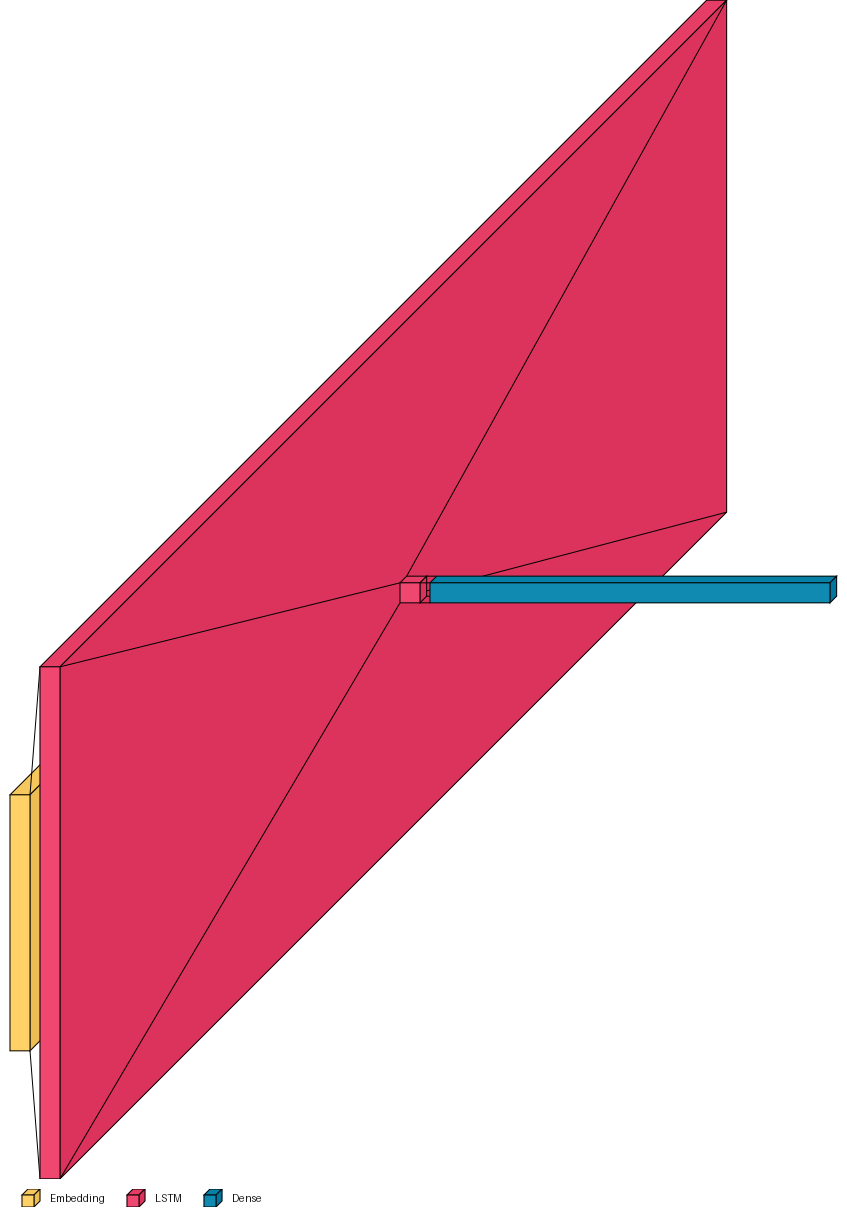

In [42]:
visualkeras.layered_view(model, legend=True)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss', marker='o')
plt.plot(history_dict['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

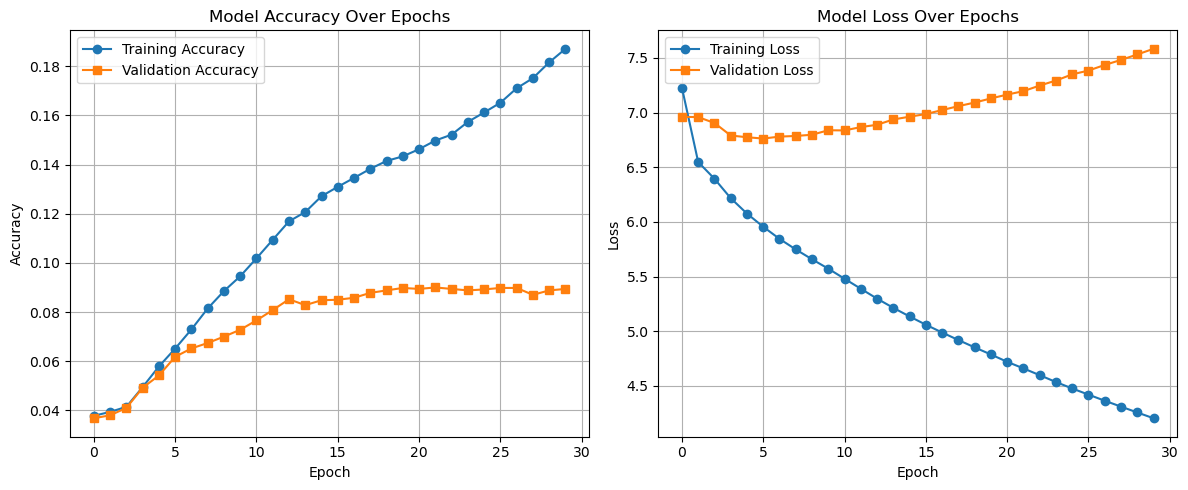



*   The addition of layers to the model architecture resulted in early-stage overfitting, indicating limited benefit from increased depth. Despite the more complex architecture, the model failed to generalize effectively, suggesting that further layering did not contribute meaningfully to performance improvement and may have adversely affected the model’s robustness.



In [ ]:
print(generate_text_word(model, tokenizer, seed_text="i hope so", num_words=15, temperature=0.7))



```
i hope so you gonna leave it to be this way in the lateral part of the stomach
```



In [43]:
# Qualitative analysis
seed_text="i hope so"
evaluate_qualitative("i hope so you gonna leave it to be this way in the lateral part of the stomach")


Qualitative Evaluation:
Coherence and Grammar: Good
Creativity: Interesting
Contextual Relevance: Yes
Diversity: High


In [ ]:
# Quantitative evaluation
reference_text = "i hope so. she okay? let's go. wow okay you're gonna need to learn how to lie."
generated_text = "i hope so you gonna leave it to be this way in the lateral part of the stomach"
# BLEU
bleu = calculate_bleu_score(reference_text, generated_text)
print(f"BLEU Score: {bleu:.4f}")

# ROUGE
rouge = calculate_rouge(reference_text, generated_text)
print(f"ROUGE Scores: {rouge}")

# Entropy & Repetition
entropy, repetition = calculate_entropy_and_repetition(generated_text)
print(f"Entropy: {entropy:.4f}")
print(f"Repetition Ratio: {repetition:.4f}")



```
BLEU Score: 0.0000
ROUGE Scores: {'rouge1': Score(precision=0.3333333333333333, recall=0.3157894736842105, fmeasure=0.3243243243243243), 'rouge2': Score(precision=0.11764705882352941, recall=0.1111111111111111, fmeasure=0.11428571428571428), 'rougeL': Score(precision=0.3333333333333333, recall=0.3157894736842105, fmeasure=0.3243243243243243)}
Entropy: 2.8134
Repetition Ratio: 0.0556
```





*   Increasing the number of layers did not lead to significant quantitative improvements in model performance. While the training time increased substantially, the evaluation metrics remained largely unchanged.



**Fine tuning a model**

Our initial experiments revealed that while the LSTM-based architecture is computationally intensive, it often yields suboptimal performance. To address these limitations in both efficiency and output quality, we propose an alternative approach.

Specifically, we adopt a pre-trained language model. As demonstrated by Chung et al. (2020), pre-trained models significantly reduce training time and enhance the quality of generated text by leveraging representations learned from large-scale corpora. This allows for more effective fine-tuning on downstream tasks, even under constrained data and computational resources.

Given our limited environment in terms of time and computational capacity, this strategy represents the most viable and effective solution.

We fine-tuned gpt-2.0 model using cornel movie corpus data.

In [ ]:
# Install gpt 2.0 model
!pip install gpt_2_simple

In [ ]:
# Data preparation
joined_text = "\n".join(cleaned_dialogues)

In [ ]:
# Organize dataset for fine-tuning
with open("output.txt", "w", encoding="utf-8") as f:
    f.write(joined_text)

In [ ]:
import gpt_2_simple as gpt2
import tensorflow as tf
gpt2.download_gpt2(model_name='124M')
sess = gpt2.start_tf_sess()
gpt2.finetune(sess,dataset='/content/output.txt'
             ,model_name='124M'
             ,steps=200
             ,print_every=200
             ,sample_every=100,
              restore_from='fresh'

             )



```
Fetching checkpoint: 1.05Mit [00:00, 3.84Git/s]                                                     
Fetching encoder.json: 1.05Mit [00:02, 519kit/s]
Fetching hparams.json: 1.05Mit [00:00, 5.10Git/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 498Mit [02:56, 2.82Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 3.27Git/s]                                               
Fetching model.ckpt.meta: 1.05Mit [00:01, 878kit/s]
Fetching vocab.bpe: 1.05Mit [00:01, 872kit/s]
Loading checkpoint models/124M/model.ckpt
Loading dataset...
100%|██████████| 1/1 [00:15<00:00, 15.14s/it]
dataset has 4667336 tokens
Training...
======== SAMPLE 1 ========
 a you're doing a goddamn thing right now, he's doing a goddamn thing. that's a fucking thing. that's just something to fucking get a feel yourself. that's not good, and he's still good enough to do it like,

your dad is a fucking dope. the only thing i don't like is he's the only goddamn thing fucking nice about it.

i didn't watch any of that kid play baseball. i was just getting started.

i guess it's just you, or it just gets worse and worse.

not that you don't like it.

yeah, but you'd be the better coach. there's just no way you'd ever get that out of me, anyway. i can tell you who's better, my dad.

hey, look!
oh, you know, he's great!
yeah, but you're too goddamn smart.
you wouldn't. you'd call yourself the smartest person in the room.
it was nice. i could see what was taking place.
well, it's gotta be nice.
you, uh, i don't know anyone like that. you want me to meet those guys?
you gotta be super smart, you fucking idiot. you're gonna be better later, right? look, i can't wait for them to see my dad.
you want to do that? you want to work on me, man?
you really want to do that?
i want to know. can you talk to me? i mean, can you? you're going to tell him i'm doing anything?
he's gonna say, 'goodnight, man' then, like my daddy used to say, 'hey, look at this!'
i'm never gonna go out here. you're gonna say something stupid.
it's just a game. the other day, i was playing with this guy, so he was like, 'yeah, the same guy i told you to meet the next day. 'but all he wants is a little something.' and we had two games where he was just going down, yelling at me. and i just stood there, not talking to him. and no one would know who was in that fight. it was just him and me.
i'd been thinking about this thing for days.
just a game. it's like you're playing poker in my house. all we're gonna do is say, 'what happened to my dad?' 'uhm', man, you're going to say that a lot. you're going to make me look like some freak.
i always think i understand something about that kid.
no.
no, but it's gotta be good. it's gotta be good.
and then it was like, 'look, you know what i'm talking about, but then you start telling me things you shouldn't even do.
oh, man, you're so fucking smart. you really know what i'm talking about with that kid.
i mean, if you'd just come back and put me on my own as a wrestler, my dad would be the best coach in the world.
i mean, come on, you wanna be good for your friends?
not because you wanna stay there with your mom.
no. but because you wanna be good for the people you live with.
who doesn't want that?
oh, my god. the guy's just trying to get that old school kid on his side, and that's what the whole thing's gonna look like.
he had a fight and a fight and he's gonna be all over you.
yeah.
it was. my dad.
he was a good wrestler. he fought big.
yeah. he's just kinda good.
it's like the ol' thing.
yeah. all you have to do is get into that fight and you can stay away.
that was great.
i don't know.
it was a good fight. great.
yeah. that was great.
he's playing poker. that's great.
he's playing poker.
that's great.
oh, my god. that's great.
oh yeah. that was great.
oh yeah.
it was really great.
uhm. uhh mm. that's great. that's great.
the guy was good. then. it's like the first one's gonna knock you out the first time.
oh. yeah?
okay?
oh, he was.
oh, he was...
yes. he's...
oh uhh mm. yay!
oh, yeah. he's a good wrestler.
i'm not going to talk to you about that. i'm going to give you a call, and you could do something.
what? how you feeling?
oh, yeah. he's the guy.
you're gonna like him

[200 | 496.52] loss=3.17 avg=3.17
Saving checkpoint/run1/model-200
```





*   Pick up one of the generated texts to see performance



In [ ]:
# Qualitative evaluation
seed_text = "i'm not going"
evaluate_qualitative("i'm not going to talk to you about that. i'm going to give you a call, and you could do something.")

```

Qualitative Evaluation:
Coherence and Grammar: Good
Creativity: Interesting
Contextual Relevance: Yes
Diversity: High
```



In [ ]:
generated_text = "i'm not going to talk to you about that. i'm going to give you a call, and you could do something."

# 2. BLEU Score Calculation
reference_text = "i'm not going to talk about her anymore. i thought you'd appreciate that."
bleu_score = calculate_bleu(reference_text, generated_text)
print("BLEU Score:", bleu_score)

# 3. ROUGE Score Calculation
rouge_scores = calculate_rouge(reference_text, generated_text)
print("ROUGE Score:", rouge_scores)

# 4. Entropy and Repetition Metrics
entropy_score, repetition_score = calculate_entropy_and_repetition(generated_text)
print("Entropy Score:", entropy_score)
print("Repetition Score:", repetition_score)

```
BLEU Score: 0.1849304691034943
ROUGE Score: {'rouge-1': {'r': 0.5384615384615384, 'p': 0.4666666666666667, 'f': 0.4999999950255103}, 'rouge-2': {'r': 0.3333333333333333, 'p': 0.21052631578947367, 'f': 0.2580645113839751}, 'rouge-l': {'r': 0.5384615384615384, 'p': 0.4666666666666667, 'f': 0.4999999950255103}}
Entropy Score: 3.909741765391666
Repetition Score: 0.7755102040816326
```



**Result**

*   Training time was dramatically decreased, LSTM model took from 60 seconds to 600 seconds per epoch, but this fine-tuning completed less than 5 minutes.
*   Due to lack of reference texts, quantitative evaluation is poor, but gramaticaly, fine-tuned model's output is readable, and make it sence for human readers.

